### ARTIFICIAL INTELLIGENCE FOR ROBOTICS I: REINFORCEMENT LEARNING PROJECT
### Mountain Car Q-Learning
 
### Aim of the Project: 
 Using Q-learning algorithm, teaching the agent how to the reach goal point in a mountain. 
 Agent can takes position and veloicty values of the car from the environment, and tries to reach the goal point in a reinforcement learning based model.
 Training consists of 10000 iterations, the learning and the exploration rates are decreased in each iteration in order to converge faster
 The environment is continues so it needs to be discretized, in order to discretization process Kbins Discretization method is used.
 Results are given not only by plotting reward and time relationship but also video clips for randomly chosen iterations using gym package. 
In order to obtain video results, a folder called MountainCar should be created in the users Pc.
 It can be seen that the agent can reach the goal point by updating Q-table.

### Q-Learning:

 Q-Learning is an off-policy value-based method that uses a TD approach to train its action-value function.
 Q-Learning basically consists of 4 steps:
 1. Initialize the Q-table
    We need to initialize the Q-table for each state-action pair. Most of the time, we initialize with values of 0.
 2. Choose action using epsilon-greedy strategy
    Epsilon greedy strategy is a policy that handles the exploration/exploitation trade-off.
    The idea is that we define the initial epsilon ɛ = 1.0:
    With probability 1 — ɛ : we do exploitation (aka our agent selects the action with the highest state-action pair value).
    With probability ɛ: we do exploration (trying random action).
    At the beginning of the training, the probability of doing exploration will be huge since ɛ is very high, so most of the time, agent explores. But as the training goes on, and consequently our Q-table gets better and better in its estimations, we progressively reduce the epsilon value since we will need less and less exploration and more exploitation.
 3. Perform action At, gets reward Rt+1 and next state St+1
 4. Update Q(St, At)
     in TD Learning, we update our policy or value function (depending on the RL method we choose) after one step of the interaction.


In [1]:
# Necessary packages
import gym                                          # Environment framework
from math import log10, pow, ceil                   # Two math functions
import numpy as np                                  # Advanced math + syntactic sugar
from pandas import Series                           # To make one piece of math easier
from sklearn.preprocessing import KBinsDiscretizer  # Discretization made easy
import matplotlib.pyplot as plt                     # Graph generation
import cv2                                          # Video export code
import time                                         # Stopwatch for training time
import csv
import json
import os

### This part of the code is for showing the results as video for randomly chosen episodes
 Finds the created folder then it created video clips inside it.
 Before running this part of the code, please create a folder called MountainCar in you pc
 All training results will be in this folder.


In [4]:
cwd = os.getcwd()
videosPath = os.path.join(cwd,'MountainCar')
os.mkdir(videosPath)

### Decleration of the control variables
 The agent is trained for 10000 episodes and learning coefficient is taken as 1 at first and exploration coefficient is taken as 0.02 which means the agent tries the states that it does not know and this rate is decreased when the agent starts to learn.


### Control Panel

In [ ]:
n_episodes = 10000                              # Number of total attempts
learning_coeff = 1
learning_decay = 0.25
exploration_coeff = 0.02                       #exploration coefficient
exploration_decay = 0.0
min_learn = 0.003
min_explore = 0.0
discount = 1.0

In [ ]:
n_bins = (14, 14)                       # Bin size configuration
lower_bounds = [-1.2, -0.07]            # Manual values are specified for parts of the environment state
upper_bounds = [0.6, 0.07]              # using env.state() command

### Helpers

In [ ]:
def regularInterval(n, ep):
    return [*range(0,ep,n)]
capture_eps = [0, 250, 500, 750, 1500, 2500, 3000, 4000, 5000, 6000, 7000, 8500, 9900]    # Export a video every N iterations

reward_update_interval = n_episodes+1           # (debug) print out total reward for every Nth iteration
export_fps = 30                                 # frames per second of video export

min_reward = -200                               # min reward is declared
max_reward = 0                                  # max reward is declared 

### Graph initialization

In [ ]:
graph_x = np.arange(n_episodes)
graph_learn = np.zeros(n_episodes)
graph_explore = np.zeros(n_episodes)
rewards = np.zeros(n_episodes)

### Mountain Car is a continuous world so it needs to be discretized 
 Different methods are available but in this case it is used KBinsdiscretizer. 
 It takes continues values from the environment and selects a bin for each of them for using Q-table


### Functions

In [ ]:
# Discretization method
def discretizer(car_position, car_velocity):
    # This automatically determines the bin sizes and locations
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds])
    return tuple(map(int,est.transform([[car_position, car_velocity]])[0]))

### Using policy Q table is updatedwith the new values
 
 Policy is choosing the maximum Q from the table for each step. It is shown in the formula below:
 
 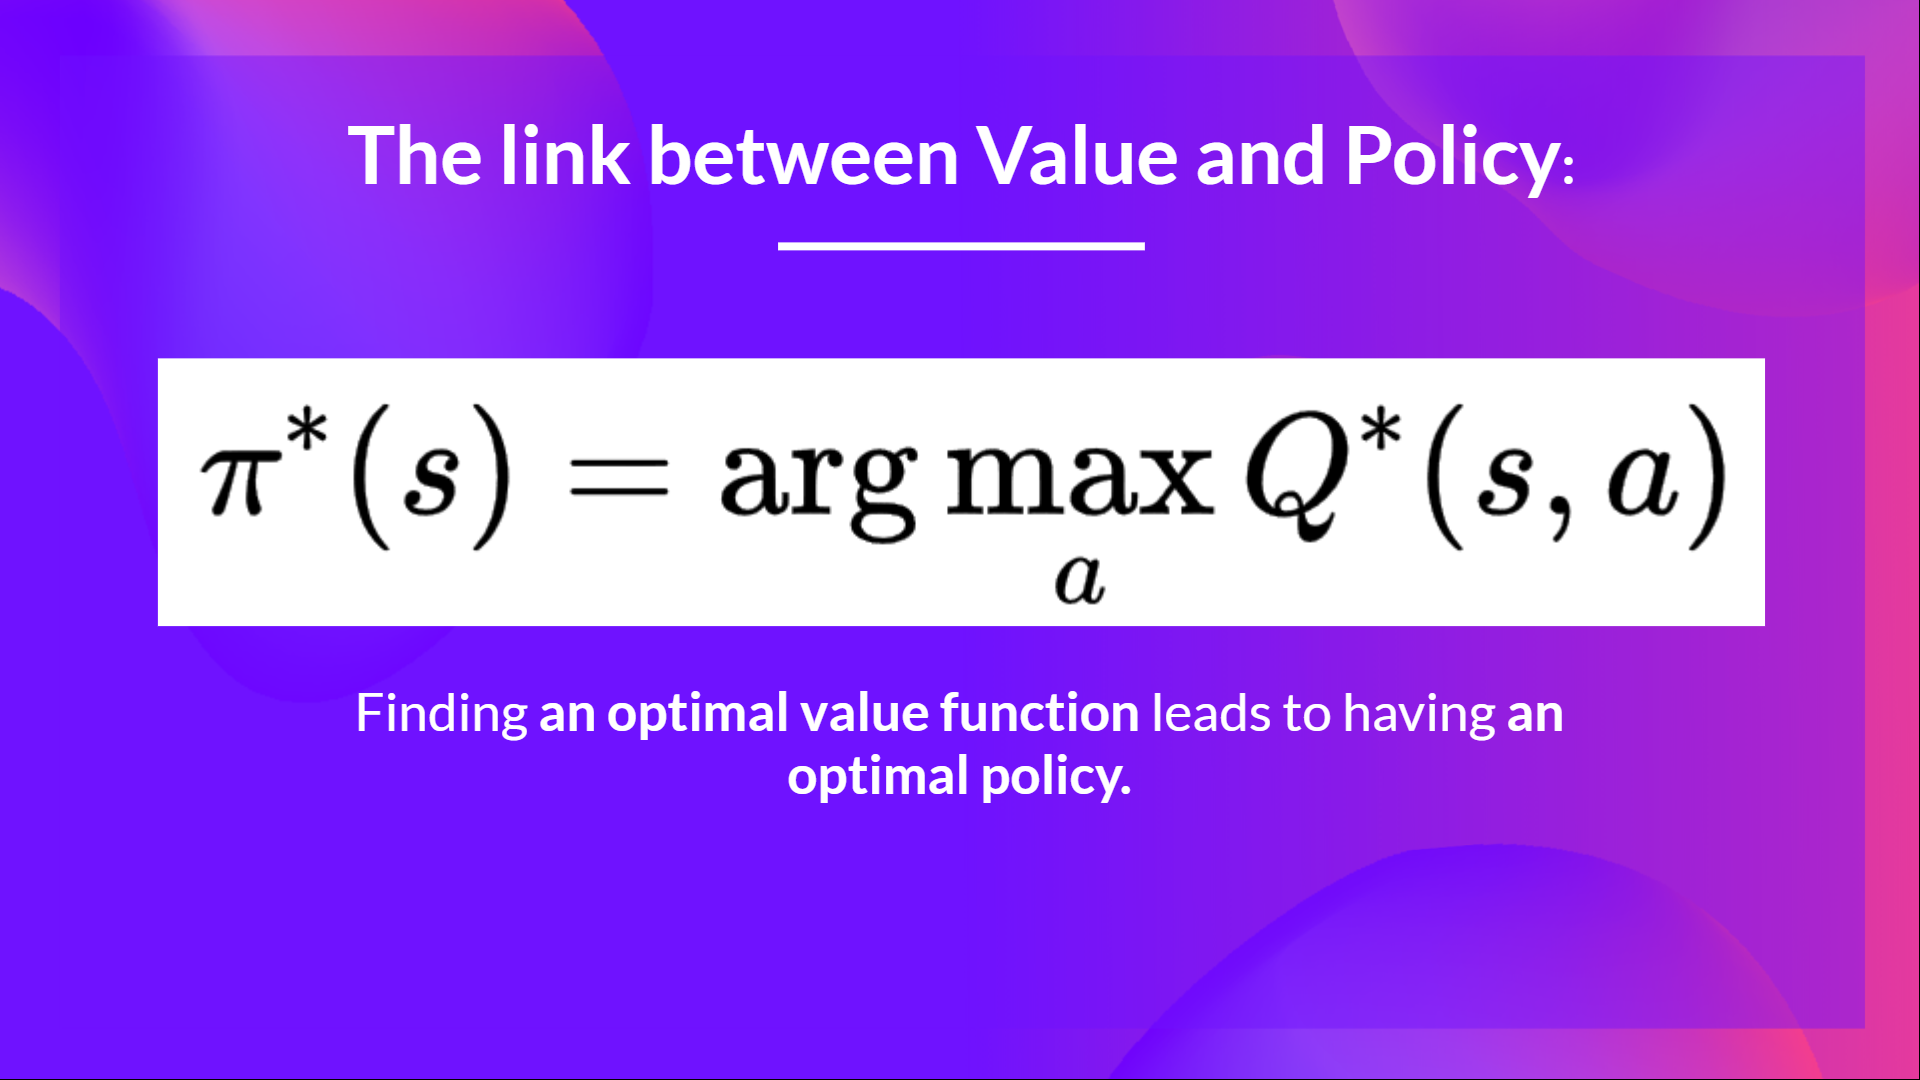
 
 In order to choose new q values the formula below is used:
 
 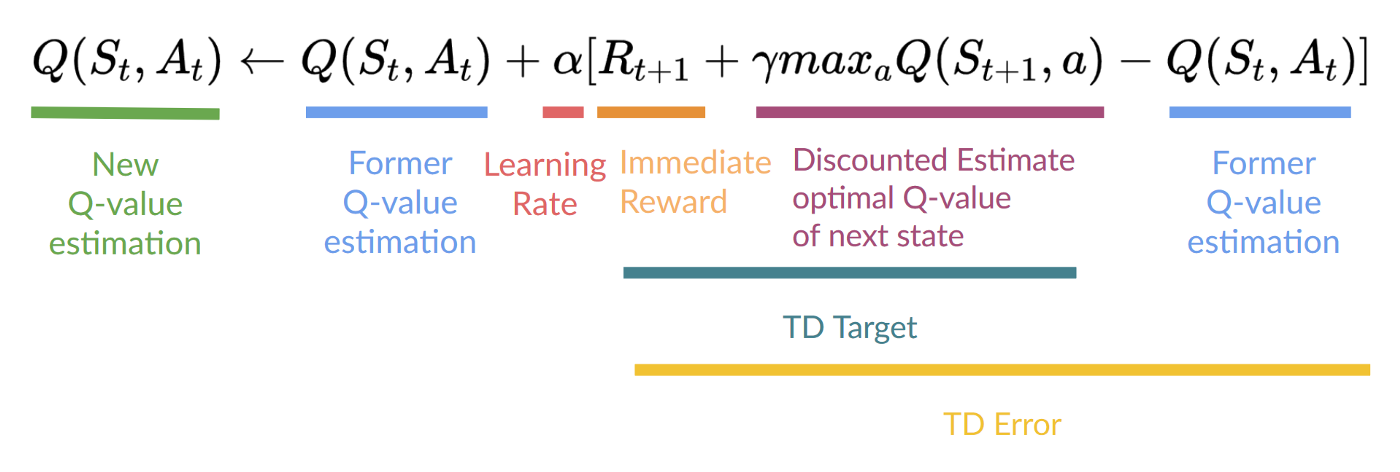
 
 In this case discount factor is taken as 1 and learning rate is changing in each iteration starting from 1.


In [ ]:
# Policy (how the AI chooses an action each iteration)
def policy(state):
    # The agent uses a greedy strategy to select the best action it knows at the given moment
    return np.argmax(Q_table[state])

# Q-value maths
def new_Q_value(reward, new_state, discount_factor = discount):
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

In order to reach the results learning rate and exploration rate are updated in each iteration 

In [ ]:
# Modulate the AI's 'curiosity' over time
def exploration_rate(n, min_rate = min_explore):
    return exploration_coeff * pow(1-exploration_decay, n)

# Modulate the AI's willingness to learn over time
def learning_rate(n, min_rate = min_learn):
    return max(min_rate, learning_coeff * pow(1-learning_decay, n//100))

### The loop starts from here and ends when all the seeds are completed 
 Environment is created using gym.make() and env.reset() commands. 
 Q table is initialized and fulled with zeros at the beginning.

### Setup 

In [ ]:
# Initialize environment
env = gym.make("MountainCar-v0", render_mode='rgb_array') 
env.reset()

# Q-table initialization (all zeros across all bins)
Q_table = np.zeros(n_bins + (env.action_space.n,))

# Start timer to record training time (training only, not video export)
totalTime = 0

# Adds randomly selected iteration results to the video path
targetVideoPath = os.path.join(videosPath, f"experiment\\")
os.mkdir(targetVideoPath)

### The Game Loop starts from here
 It continues until 10000 episodes. In this part, action is updated for each iteration and Q table is updated using the new state. 
 Rewards are calculated note that minimum reward is -200 which means car does not reach the flag within the specified time.


In [ ]:
for i in range(n_episodes):
    # Reset environment for fresh run
    observation, info = env.reset()
    current_state, terminated, truncated = discretizer(*observation), False, False

    # Stat tracking
    total_reward_this_run = 0

    # Set up recording every capture point. This part is for creating videos for specific iterations
    out_video = None
    if i in capture_eps:
        print(f"Setting up video export for iteration {i}...")
        height, width, _ = env.render().shape
        out_video = cv2.VideoWriter(
            f"{targetVideoPath}iter_{str(i).zfill(ceil(log10(n_episodes)))}.mp4", 
            cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height),True)

    while not terminated and not truncated:
        # Start stopwatch for this iteration
        startTime = time.time()

        # Policy action
        action = policy(current_state)
        # Insert random action
        if np.random.random() < exploration_rate(i):
            action = env.action_space.sample()

        # Increment environment
        observation, reward, terminated, truncated, info = env.step(action)
        new_state = discretizer(*observation)

        # Update Q-table
        lr = learning_rate(i)
        learnt_value = new_Q_value(reward, new_state)
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value

        # Update state
        current_state = new_state

        # Stats update
        total_reward_this_run += reward # max reward in this simulation is 1
        # Add training time for this iteration to accumulator
        endTime = time.time()
        totalTime += endTime - startTime

        # Render environment
        if i in capture_eps:
            out_video.write(env.render())

    # Export video
    if i in capture_eps:
        print(f"Writing video for iteration {i}...")
        print(f"Total Reward {total_reward_this_run}")
        out_video.release()

    # Update graph data
    graph_learn[i] = learning_rate(i)
    graph_explore[i] = exploration_rate(i)
    rewards[i] = total_reward_this_run


### Display graph of reward 

In [ ]:
plt.title("Reward over time")
plt.xlim(0,n_episodes)
plt.ylim(min_reward-5, max_reward+5)
plt.ylabel("rewards")
plt.xlabel("iteration number")
plt.plot(graph_x, rewards, color="blue", label="Iteration Reward")
plt.legend()
plt.show()
# Display graph of learning exploration rate
plt.title("Learning/Exploration Rate over time")
plt.xlim(0,n_episodes)
plt.ylim(-0.025, 1.025)
plt.ylabel("rates")
plt.xlabel("iteration number")
plt.plot(graph_x, graph_learn, color="green", label="Learning rate")
plt.plot(graph_x, graph_explore, color="red", label="Exploration rate")
plt.legend()
plt.show()
plt.show()

### Printing some important information at the end 

In [ ]:
print(f"Episodes:{n_episodes}")
print(f"Learning Coeff:{learning_coeff},Learning Decay:{learning_decay}")
print(f"Exploration Coeff:{exploration_coeff},Exploration Decay:{exploration_decay}")
print(f"Min Learning Rate:{min_learn},Min Exploration Rate:{min_explore}")
print(f"Discount:{discount}, Capture Episode:{capture_eps}")
trainM, trainS = map(int,divmod(totalTime, 60))
print(f"\nTotal training time: {trainM}:{trainS:02}")

#close the environment
env.close()

### Sources:
     https://huggingface.co/deep-rl-course/unit2/introduction?fw=pt
     https://www.youtube.com/watch?v=yMk_XtIEzH8&list=PLQVvvaa0QuDezJFIOU5wDdfy4e9vdnx-7&ab_channel=sentdex    